# Debugging DEM Inversion

Look at single-pixel DEMs to ensure that I'm not really messing something up

In [1]:
import pathlib
import copy

import astropy.units as u
import astropy.time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.colors
import sunpy.map
from astropy.visualization import quantity_support,ImageNormalize,LogStretch,AsinhStretch
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
import aiapy
import sunkit_dem
import xrtpy
import hissw

from mocksipipeline.physics.dem.data_prep import DataPrep,DataQuery

In [2]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [3]:
data_dir = pathlib.Path('../pipeline-runs/ar-test')
#data_dir = pathlib.Path('../pipeline-runs/ar-12712-test')
aia_maps = sunpy.map.Map(list((data_dir / 'AIA').glob('*.fits')))
xrt_maps = sunpy.map.Map(list((data_dir / 'XRT').glob('*.fits')))
#ar_time = astropy.time.Time('2020-11-09 18:00:00')
ar_time = aia_maps[0].date
#ar_time = astropy.time.Time('2018-06-01 00:50:00')

In [4]:
correction_table = aiapy.calibrate.util.get_correction_table() 
pointing_table = aiapy.calibrate.util.get_pointing_table(ar_time-6*u.h, ar_time+6*u.h)
error_table = aiapy.calibrate.util.get_error_table()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [249]:
#dq = DataQuery(data_dir,
#               ar_time,
#               aia_error_table=error_table,
#               aia_correction_table=correction_table,
#               aia_pointing_table=pointing_table,
#               temperature_bin_edges=temperature_bin_edges,
#               use_aia_errors=True,
#              conserve_flux=False)
dq = DataPrep(map_list=aia_maps+[xrt_maps,],
              aia_error_table=error_table,
              aia_correction_table=correction_table,
              aia_pointing_table=pointing_table,
              temperature_bin_edges=temperature_bin_edges,
              use_aia_errors=False,
              conserve_flux=True,
              include_cross_calibration=True)

In [250]:
map_list = dq.map_list

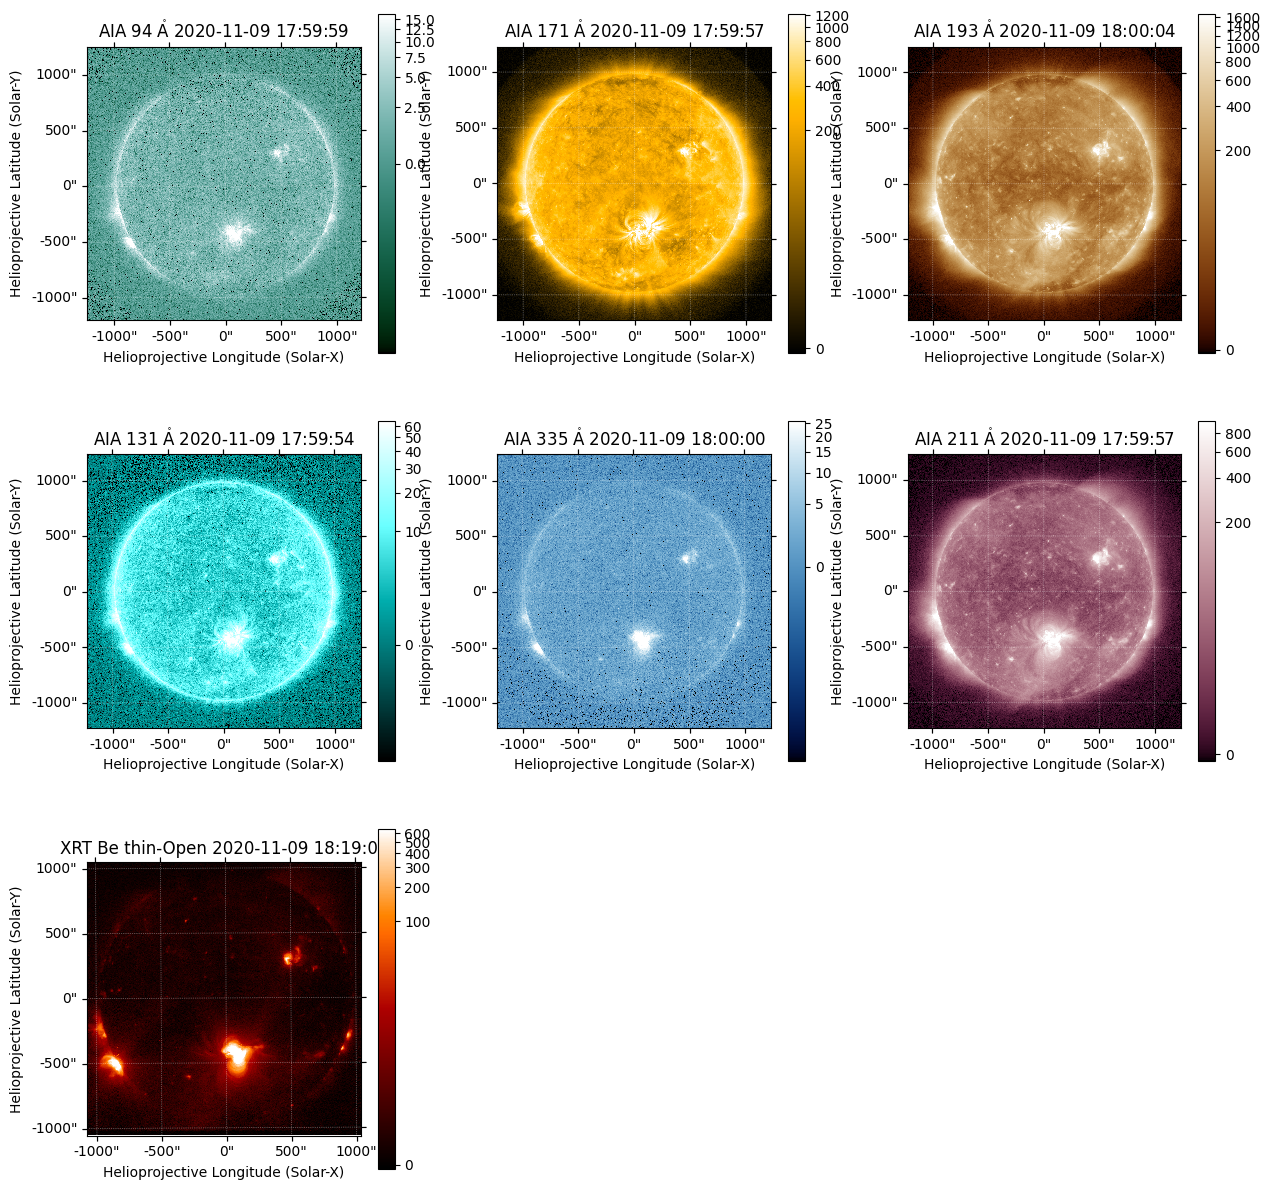

In [251]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate(map_list):
    ax = fig.add_subplot(3,3,i+1,projection=m)
    im = m.plot(axes=ax, clip_interval=(1,99.7)*u.percent)
    fig.colorbar(im)

In [252]:
col = dq.collection

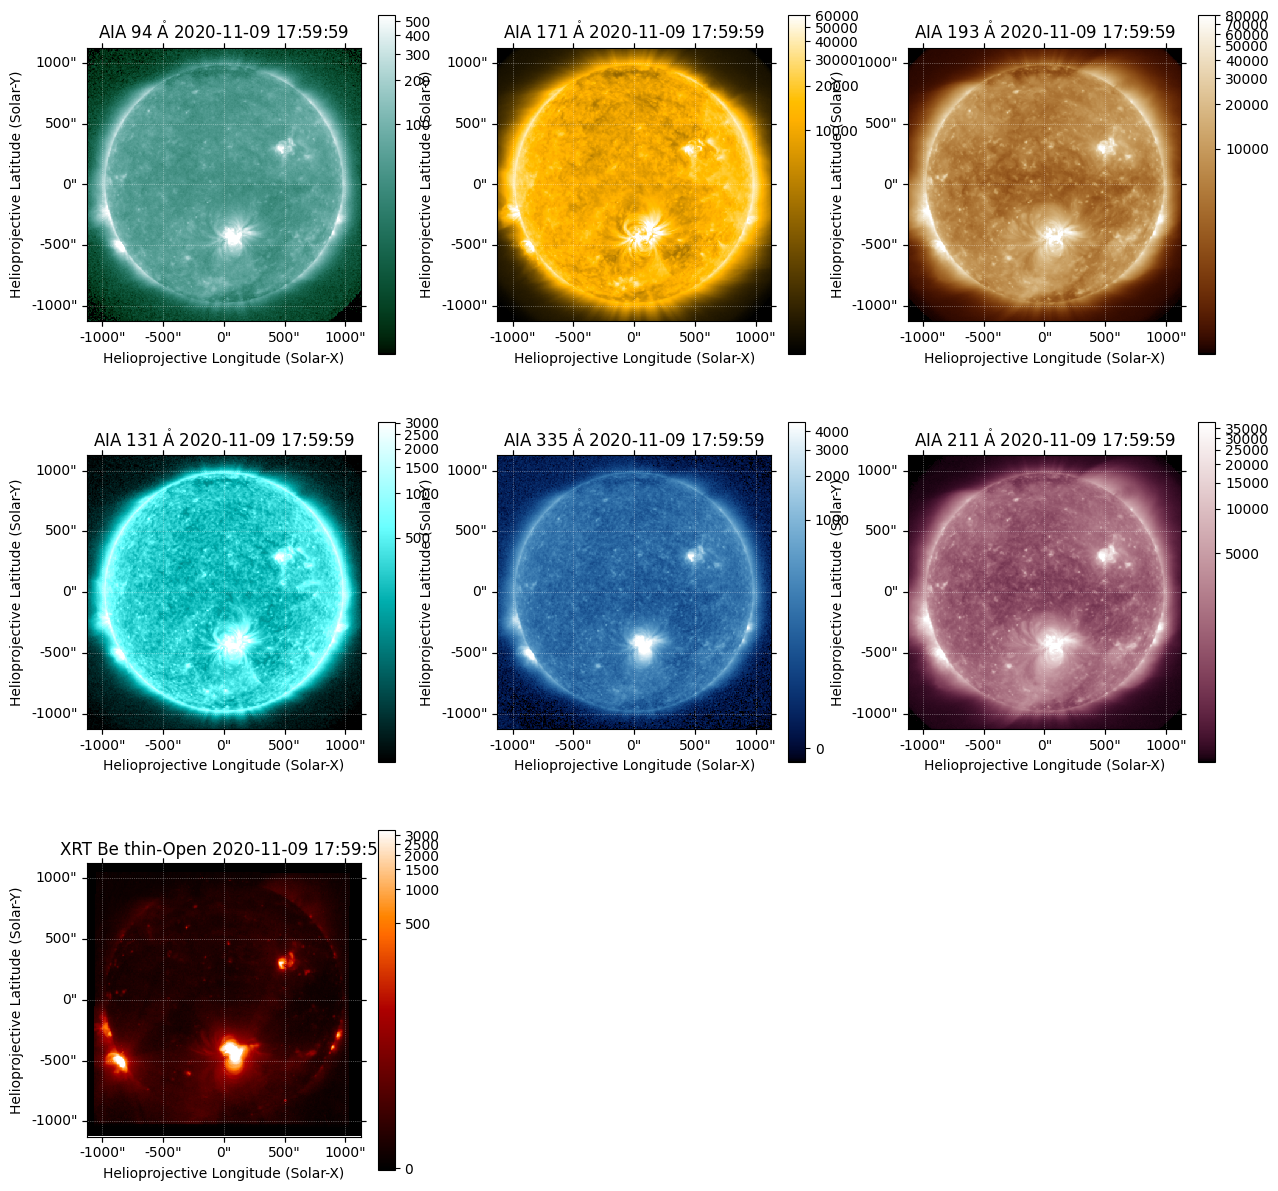

In [253]:
fig = plt.figure(figsize=(15,15))
for i,k in enumerate(col):
    ax = fig.add_subplot(3,3,i+1,projection=col[k])
    m = sunpy.map.Map(col[k].data, col[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    im = m.plot(axes=ax, clip_interval=(1,99.7)*u.percent)
    fig.colorbar(im)

In [280]:
kernels = copy.deepcopy(dq.response_kernels)

In [269]:
# Modify the Be-thin response
kernels['Be thin-Open'] /= dq.get_cross_calibration_factor('Be thin-Open')
kernels['Be thin-Open'] *= 2

Try subbing in the xrtpy version of the temperature response

In [241]:
trf = xrtpy.response.TemperatureResponseFundamental('Be-thin', xrt_maps.date)
resp_interp = np.interp(dq.temperature_bin_centers, trf.CHIANTI_temperature, trf.temperature_response())
scale_factor = (dq.new_scale[0]*dq.new_scale[1]*u.pix) / (trf.solid_angle_per_pixel)#(xrt_maps.scale.axis1 / trf.focal_len * xrt_maps.scale.axis2 / trf.focal_len * u.pix)
kernels['Be thin-Open'] = (resp_interp * u.ct / u.DN * scale_factor).to('cm5 ct pix-1 s-1')

Choose a point and extract the intensity at that point

In [270]:
flare_loc = SkyCoord(Tx=50*u.arcsec, Ty=-450*u.arcsec, frame=wcs_to_celestial_frame(dq.celestial_wcs))
#flare_loc = SkyCoord(Tx=375*u.arcsec, Ty=275*u.arcsec, frame=wcs_to_celestial_frame(dq.celestial_wcs))

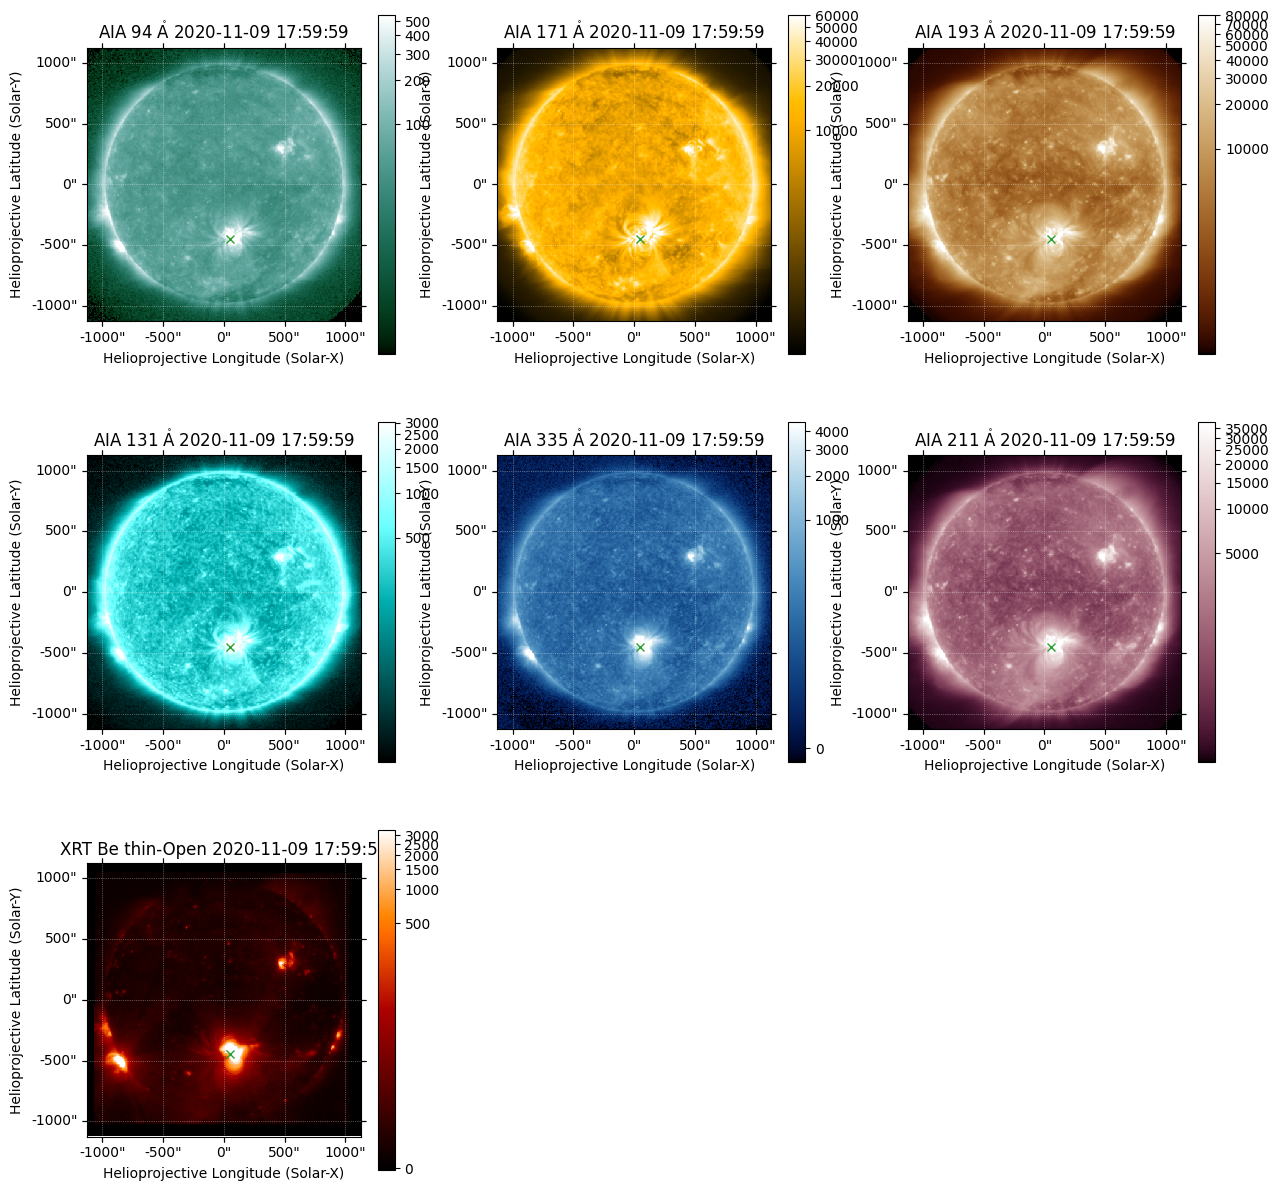

In [271]:
fig = plt.figure(figsize=(15,15))
for i,k in enumerate(col):
    ax = fig.add_subplot(3,3,i+1,projection=col[k])
    m = sunpy.map.Map(col[k].data, col[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    im = m.plot(axes=ax, clip_interval=(1,99.7)*u.percent)
    ax.plot_coord(flare_loc,marker='x',color='C2',ls='')
    fig.colorbar(im)

In [281]:
iy,ix = col['Be thin-Open'].wcs.world_to_array_index(flare_loc)
col_0D = col[iy:(iy+1), ix:(ix+1)]

Run the DEM inversion without XRT

In [282]:
col_0D_no_xrt = col_0D.copy()
col_0D_no_xrt.pop('Be thin-Open')
kernels_no_xrt = kernels.copy()
kernels_no_xrt.pop('Be thin-Open')
dem_model_no_xrt = sunkit_dem.Model(
    col_0D_no_xrt,
    kernels_no_xrt,
    dq.temperature_bin_edges,
    model='hk12',
)
dem_col_no_xrt = dem_model_no_xrt.fit(
    #alpha=2.0,
    #increase_alpha=2.0,
    #max_iterations=1000,
    #nmu=1000,
    use_em_loci=False,
    emd_int=True,
    #l_emd=True,
)

In [283]:
dem_col_no_xrt['chi_squared'].data

array([30.95532809])

In [284]:
dem_guess_no_xrt = dem_col_no_xrt['dem'].data.copy()
dem_guess_no_xrt /= dem_guess_no_xrt.max()

Now, run the DEM inversion for this single point with XRT

In [285]:
dem_model = sunkit_dem.Model(
    col_0D,
    kernels,
    dq.temperature_bin_edges,
    model='hk12',
)

In [286]:
dem_col = dem_model.fit(
    #alpha=2.0,
    #increase_alpha=1.15,
    #max_iterations=10,
    #nmu=1000,
    use_em_loci=True,
    emd_int=True,
    l_emd=True,
    #guess=dem_guess_no_xrt,
)

In [287]:
sorted_keys = sorted(col_0D.keys(), key=lambda x: float(x.split()[0]) if 'Angstrom' in x else np.inf)

94.0 Angstrom -2.958714961522176
131.0 Angstrom -2.7520976581314858
171.0 Angstrom 2.037268079989232
193.0 Angstrom -1.1391847298588036
211.0 Angstrom 4.358688432759646
335.0 Angstrom -13.779802392033895
Be thin-Open 5.355608184588192


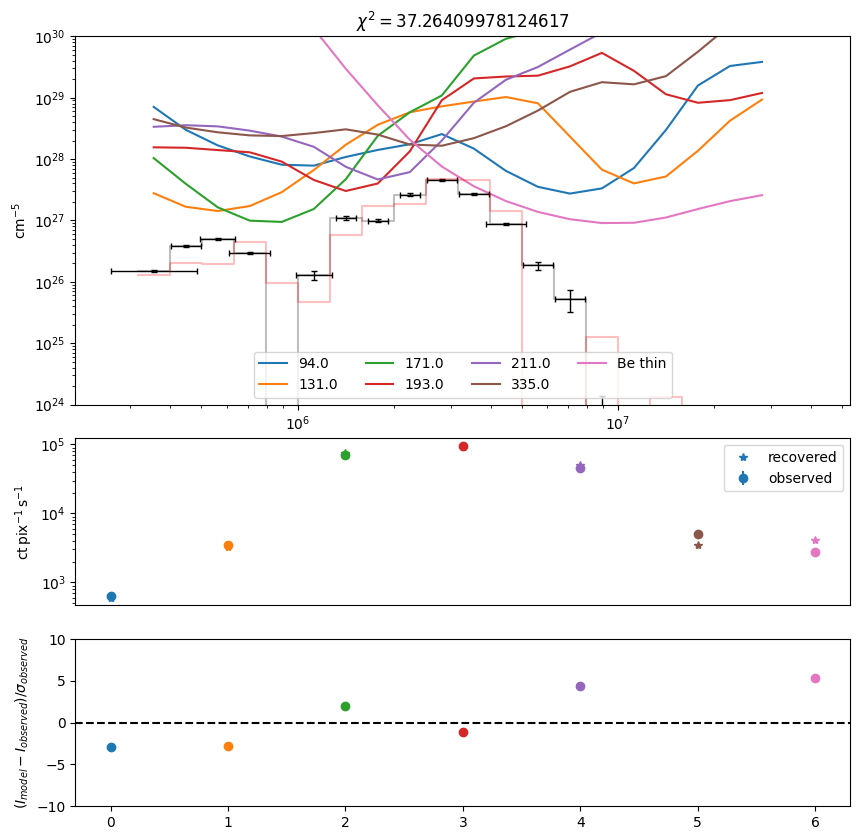

In [288]:
fig = plt.figure(figsize=(10,10))
gs = matplotlib.gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:2])
with quantity_support():
    for k in sorted_keys:
        intensity = u.Quantity(col_0D[k].data[0], col_0D[k].unit)
        em_loci = intensity / kernels[k]
        ax.plot(dq.temperature_bin_centers, em_loci, label=k.split(' ' if 'Angstrom' in k else '-')[0])
    ax.errorbar(
        dq.temperature_bin_centers.value,
        dem_col['em'].data,
        yerr=dem_col['dem'].uncertainty.array*np.diff(dq.temperature_bin_edges).value,
        xerr=u.Quantity([dem_col['temperature_errors_lower'].data,
                         dem_col['temperature_errors_upper'].data]).value,
        marker=' ',
        color='k',
        ls=' ',
        capsize=2,
        elinewidth=1
    )
    ax.step(dq.temperature_bin_edges[:-1], dem_col['em'].data, where='post', color='k', alpha=0.25)
    ax.step(dq.temperature_bin_edges[:-1], dem_col_no_xrt['em'].data, where='post', color='r', alpha=0.25)
ax.set_title(f'$\chi^2={dem_col["chi_squared"].data[0]}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e24,1e30)
ax.legend(ncol=4,loc='lower center')

recovered_intensities = {k: (dem_col['em'].data * dem_col['em'].unit * kernels[k]).sum() for k in sorted_keys}
observed_intensities = {k: col_0D[k].data.squeeze() * col_0D[k].unit for k in sorted_keys}
observed_uncertaintites = {k: col_0D[k].uncertainty.array.squeeze() * col_0D[k].unit for k in sorted_keys}
# Intensities
ax = fig.add_subplot(gs[2])
with quantity_support():
    for i,k in enumerate(sorted_keys):
        _,_,p_obs = ax.errorbar(i, observed_intensities[k], yerr=observed_uncertaintites[k], marker='o', ls='', label='observed')
        color = p_obs[0].get_color()
        p_rec, = ax.plot(i, recovered_intensities[k], marker='*', ls='', label='recovered', color=color)
        if i==0:
            ax.legend()
ax.axes.get_xaxis().set_visible(False)
ax.set_yscale('log')
# Residulas
ax = fig.add_subplot(gs[3])
for i,k in enumerate(sorted_keys):
    residual = (recovered_intensities[k] - observed_intensities[k]) / observed_uncertaintites[k]
    print(k,residual)
    ax.plot(i, residual, marker='o', ls='', label=k)
ax.axhline(y=0, color='k', ls='--')
ax.set_ylim(-10,10);
ax.set_ylabel('$(I_{model} - I_{observed}) / \sigma_{observed}$');

In [82]:
trf = xrtpy.response.TemperatureResponseFundamental('Be-thin', xrt_maps.date)

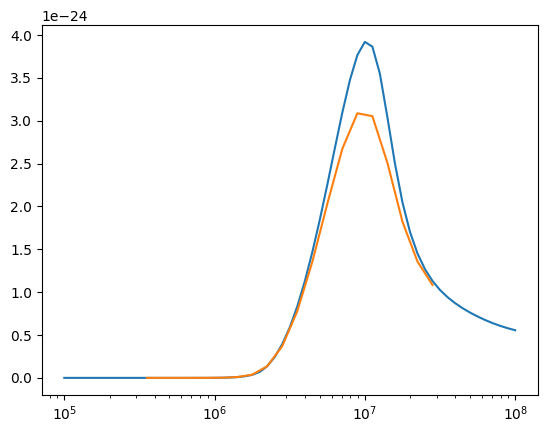

In [152]:
plt.plot(trf.CHIANTI_temperature, trf.temperature_response()*scale_factor.decompose()*dq.get_cross_calibration_factor('Be'))
plt.plot(dq.temperature_bin_centers, kernels['Be thin-Open'])
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-26,1e-22)

In [56]:
idl_env = hissw.Environment(ssw_packages=['xrt'])

In [113]:
script = """
contam_time = '{{date}}'
wave_resp = make_xrt_wave_resp(contam_time=contam_time)
temp_resp = make_xrt_temp_resp(wave_resp,/chianti_default)
"""

In [114]:
res = idl_env.run(script, verbose=True, args={'date': xrt_maps.date.isot})

IDL 8.8.2 (darwin x86_64 m64).
(c) 2022, L3Harris Geospatial Solutions, Inc.

Licensed for use by: ASA - Goddard Space Flight Center - Code 600, Science &
 Exploration Directorate, Greenbelt - Greason
License: 11426-1
A new version is available: IDL 8.8.3
https://harrisgeospatial.flexnetoperations.com
 
% Program caused arithmetic error: Floating overflow
% Compiled module: REM_ELEM.
% Compiled module: REM_ELEM2.
% Compiled module: GET_UNIQ.
% Compiled module: SSW_UNIQ.
% Compiled module: DEFAULT.
% Compiled module: DATATYPE.
% Compiled module: REMOVE.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: PRSTR.
% SSW_PATH: Path not changed Number of paths: 113
% Compiled module: SET_LOGENV.
% SET_LOGENV: setenv,SOT_CALIBRATION=$SSW_SOT/calibration
% Compiled module: HISSW_PROCEDURE.
% Compiled module: MAKE_XRT_WAVE_RESP.
% Compiled module: RSTRPOS.
% Compiled module: RESTGENX.
% Compiled module: REQUIRED_TAGS.
% Compiled module: GT_TAGVAL.
% Compiled module: STR_T

In [143]:
response_idl = {}
for chan in res['wave_resp']:
    chan_ea = chan['effar'][0]
    wave = u.Quantity(chan_ea['wave'], chan_ea['wave_units'][:-1])
    ea = u.Quantity(chan_ea['eff_area'], chan_ea['eff_area_units'])
    i_pos = np.where(wave>0*u.angstrom)
    desc = chan_ea['name'].decode('utf-8')
    name = chan['name'].decode('utf-8')
    response_idl[name] = {
        'wavelength': wave[i_pos],
        'effective_area': ea[i_pos],
        'description': desc,
    }
for chan in res['temp_resp']:
    name, chianti_version = chan['name'].decode('utf-8').split(';')
    temperature = u.Quantity(chan['temp'], chan['temp_units'])
    temperature_response = u.Quantity(chan['temp_resp'], chan['temp_resp_units'])
    response_idl[name]['temperature'] = temperature
    response_idl[name]['temperature_response'] = temperature_response

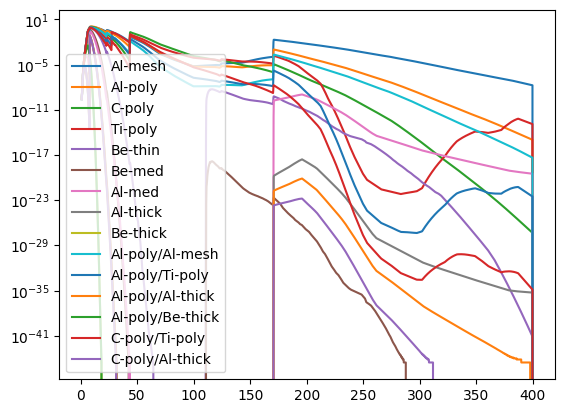

In [144]:
for k in ea_idl:
    plt.plot(ea_idl[k]['wavelength'], ea_idl[k]['effective_area'], label=k)
plt.yscale('log')
plt.legend()

(0.0, 50.0)

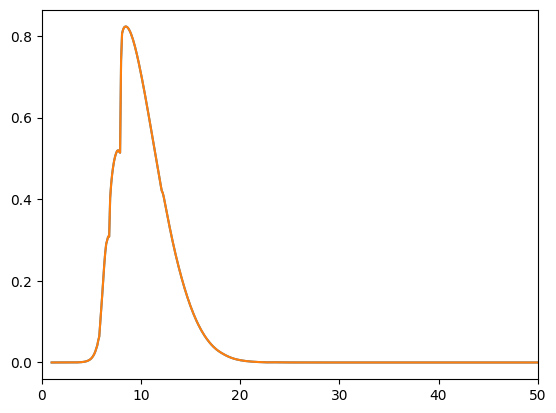

In [145]:
plt.plot(ea_idl['Be-thin']['wavelength'],
         ea_idl['Be-thin']['effective_area'])
plt.plot(trf.channel_wavelength, trf.effective_area())
plt.xlim(0,50)

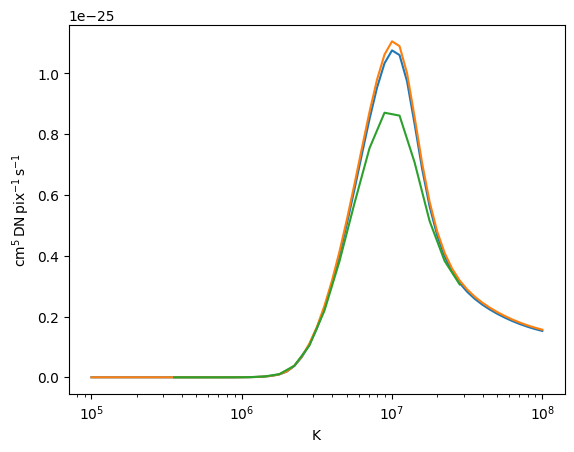

In [158]:
with quantity_support():
    plt.plot(response_idl['Be-thin']['temperature'], response_idl['Be-thin']['temperature_response'])
    plt.plot(trf.CHIANTI_temperature, trf.temperature_response(), label='xrtpy')
    scale_factor =  (trf.solid_angle_per_pixel) / (dq.new_scale[0]*dq.new_scale[1]*u.pix) * u.DN / u.ct
    plt.plot(dq.temperature_bin_centers, kernels['Be thin-Open']/dq.get_cross_calibration_factor('Be-thin')*scale_factor)
plt.xscale('log')
#plt.yscale('log')

In [155]:
m_94 = sunpy.map.Map(col['94.0 Angstrom'].data, col['94.0 Angstrom'].meta)
m_94.plot_settings["cmap"] = f'sdo{m_94.plot_settings["cmap"]}'
m_171 = sunpy.map.Map(col['171.0 Angstrom'].data, col['171.0 Angstrom'].meta)
m_171.plot_settings["cmap"] = f'sdo{m_171.plot_settings["cmap"]}'
m_be_thin = sunpy.map.Map(col['Be thin-Open'].data, col['Be thin-Open'].meta)
blc = SkyCoord(Tx=-200*u.arcsec, Ty=-700*u.arcsecond, frame=m_94.coordinate_frame)
m_94 = m_94.submap(blc, width=500*u.arcsecond, height=500*u.arcsecond)
m_be_thin = m_be_thin.submap(m_94.bottom_left_coord, top_right=m_94.top_right_coord)
m_171 = m_171.submap(m_94.bottom_left_coord, top_right=m_94.top_right_coord)

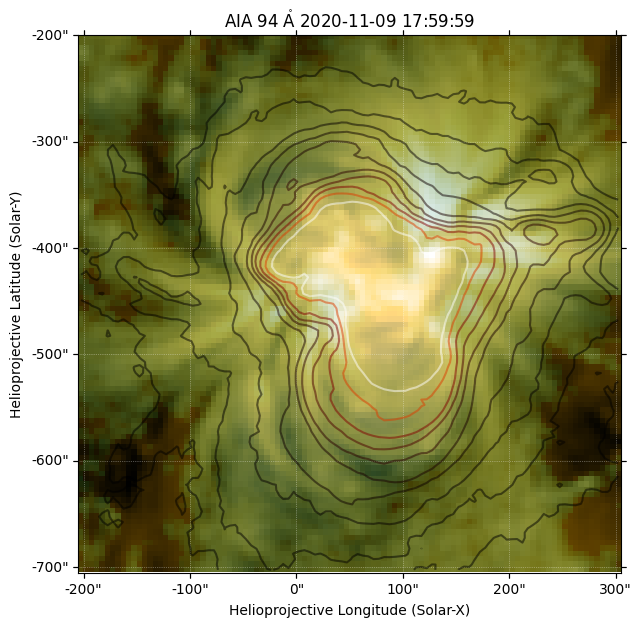

In [190]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=m_94)
m_171.plot(axes=ax,zorder=0)
m_94.plot(axes=ax, alpha=.5, clip_interval=(10,99)*u.percent)
#m_be_thin.plot(axes=ax, alpha=0.3, clip_interval=(1,99.5)*u.percent,)
m_be_thin.draw_contours(axes=ax,levels=np.logspace(-1,1,10)*u.percent,cmap='hinodexrt',alpha=0.5)
#m_94.draw_contours(axes=ax,levels=np.arange(0.2,50,5)*u.percent,cmap='sdoaia94',alpha=0.5)

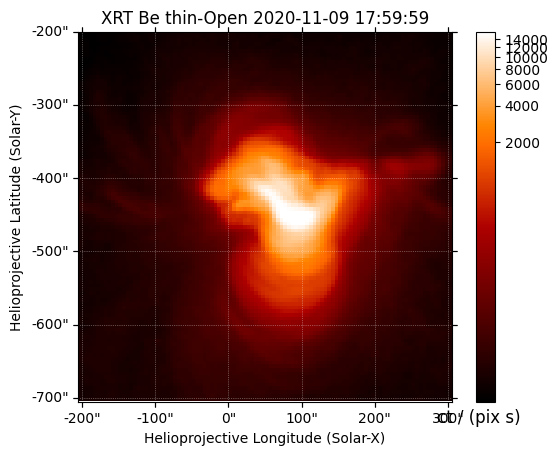

In [129]:
m_be_thin.peek()